In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

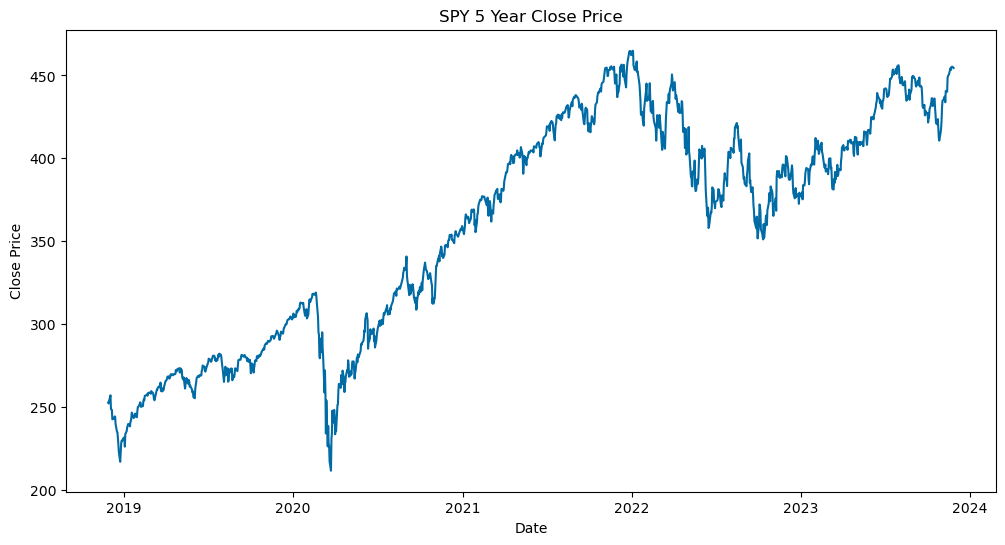

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=301.739108, mean2=415.419070, mean_percent_diff=37.674918
variance1=2080.748070, variance2=686.284031, var_percent_diff=-67.017438


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.342506
p-value: 0.609509
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.909075295322877, 0.01, 20, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.91
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

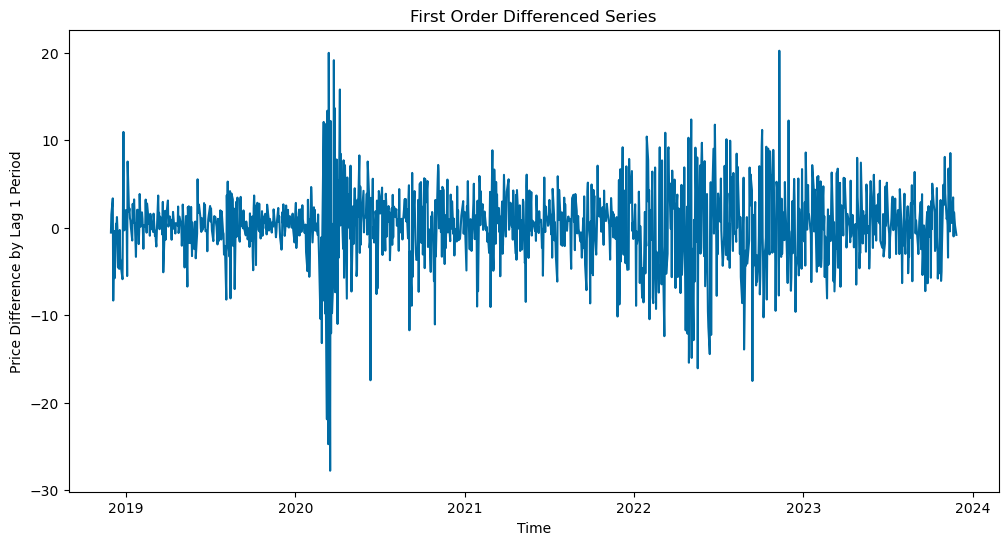

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.878968
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3042.180353316021
BIC = 3052.005838957007
Time Series Evaluation Metrics
MSE = 1005.4931720851591
MAE = 25.828228685253567
RMSE = 31.70951232808791
MAPE = 0.059812422175701555
r2 = -0.9111635048206792



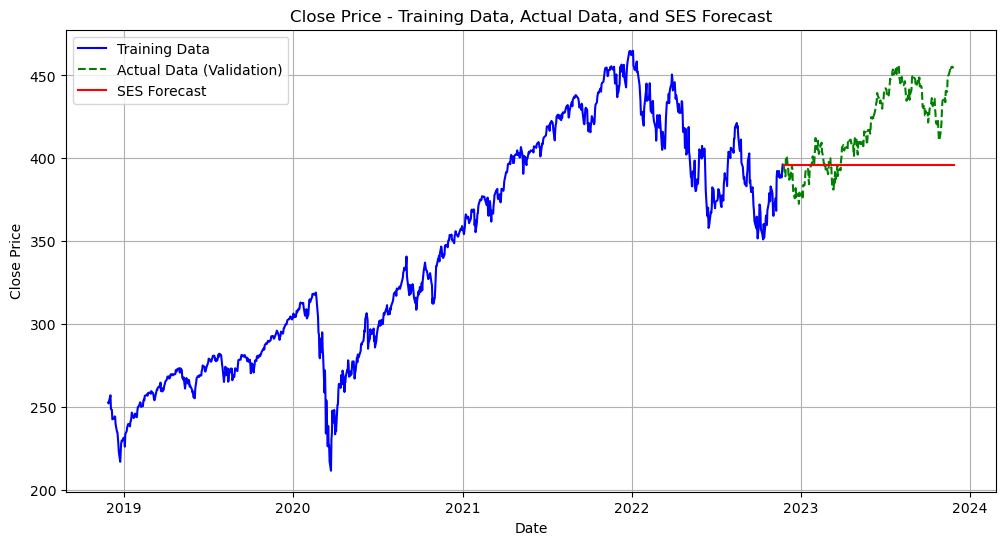

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

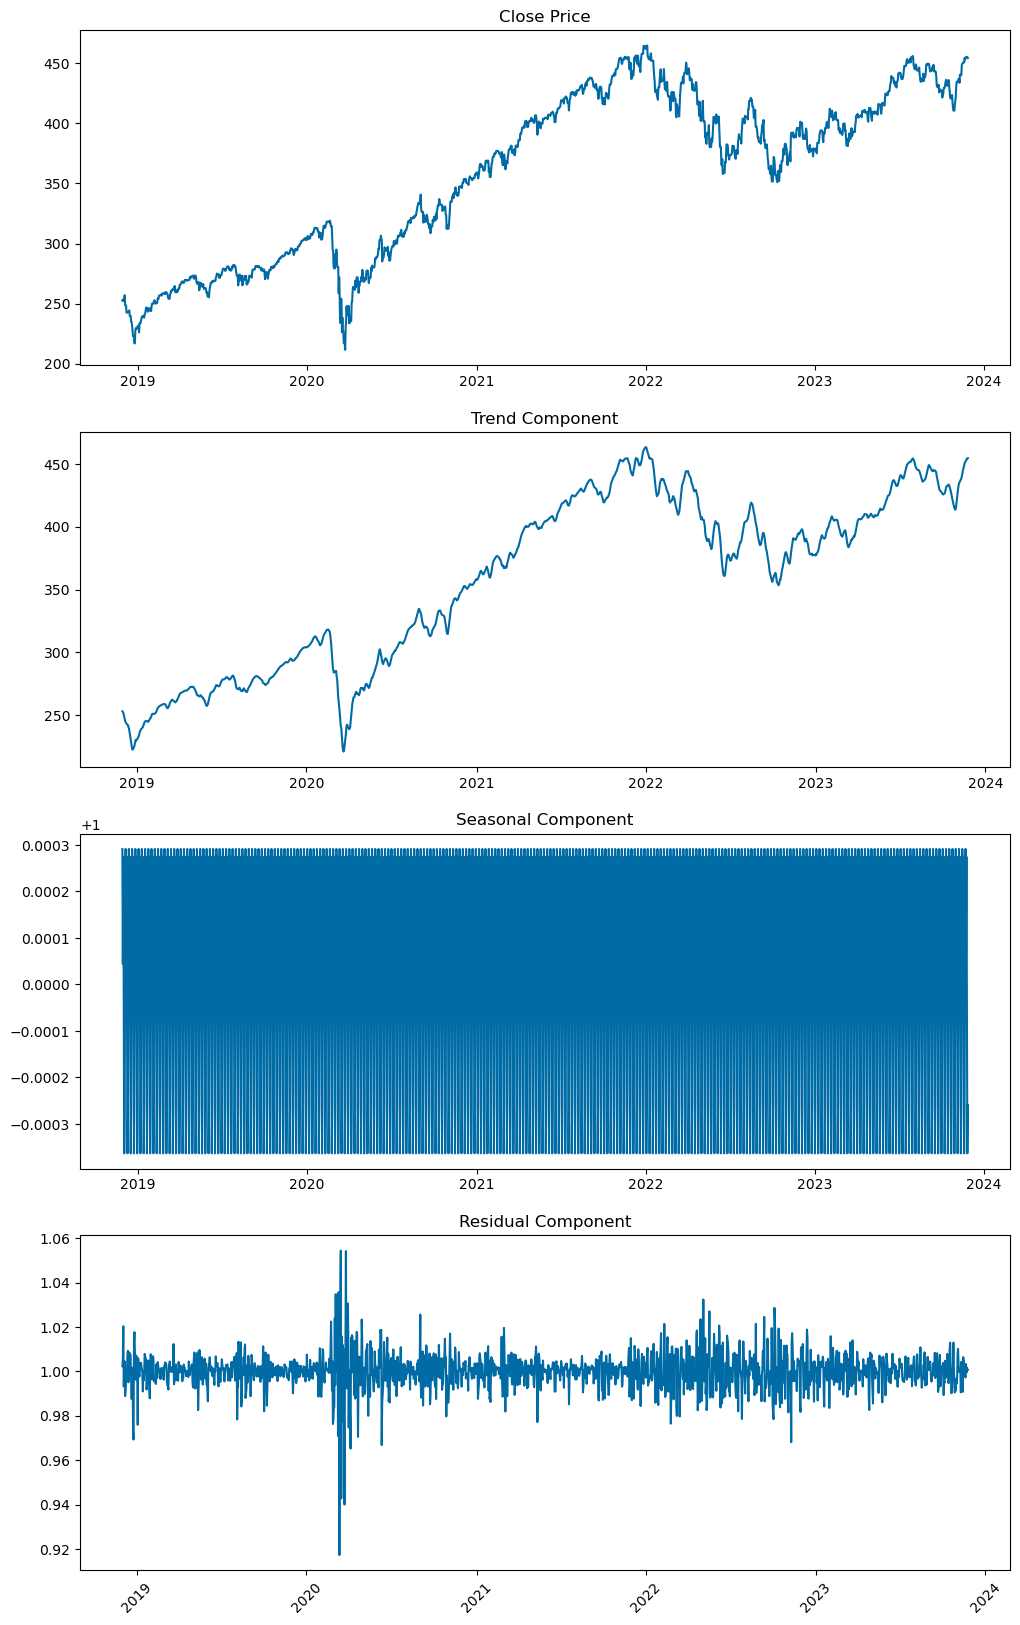

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

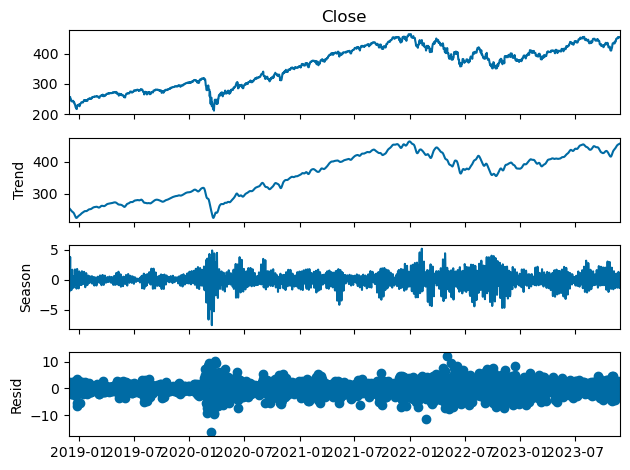

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

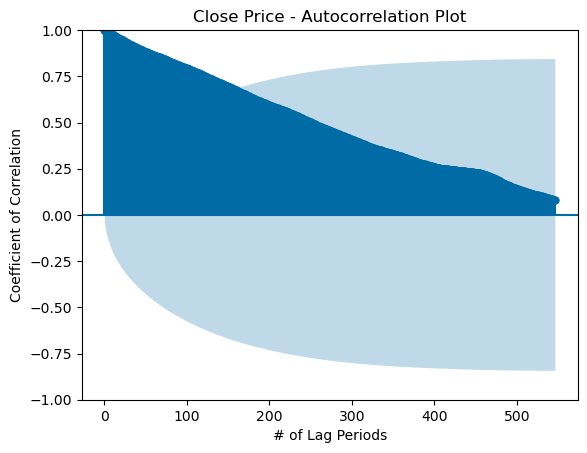

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

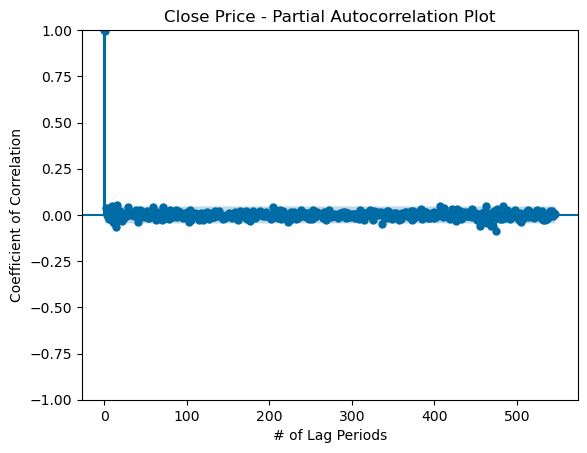

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

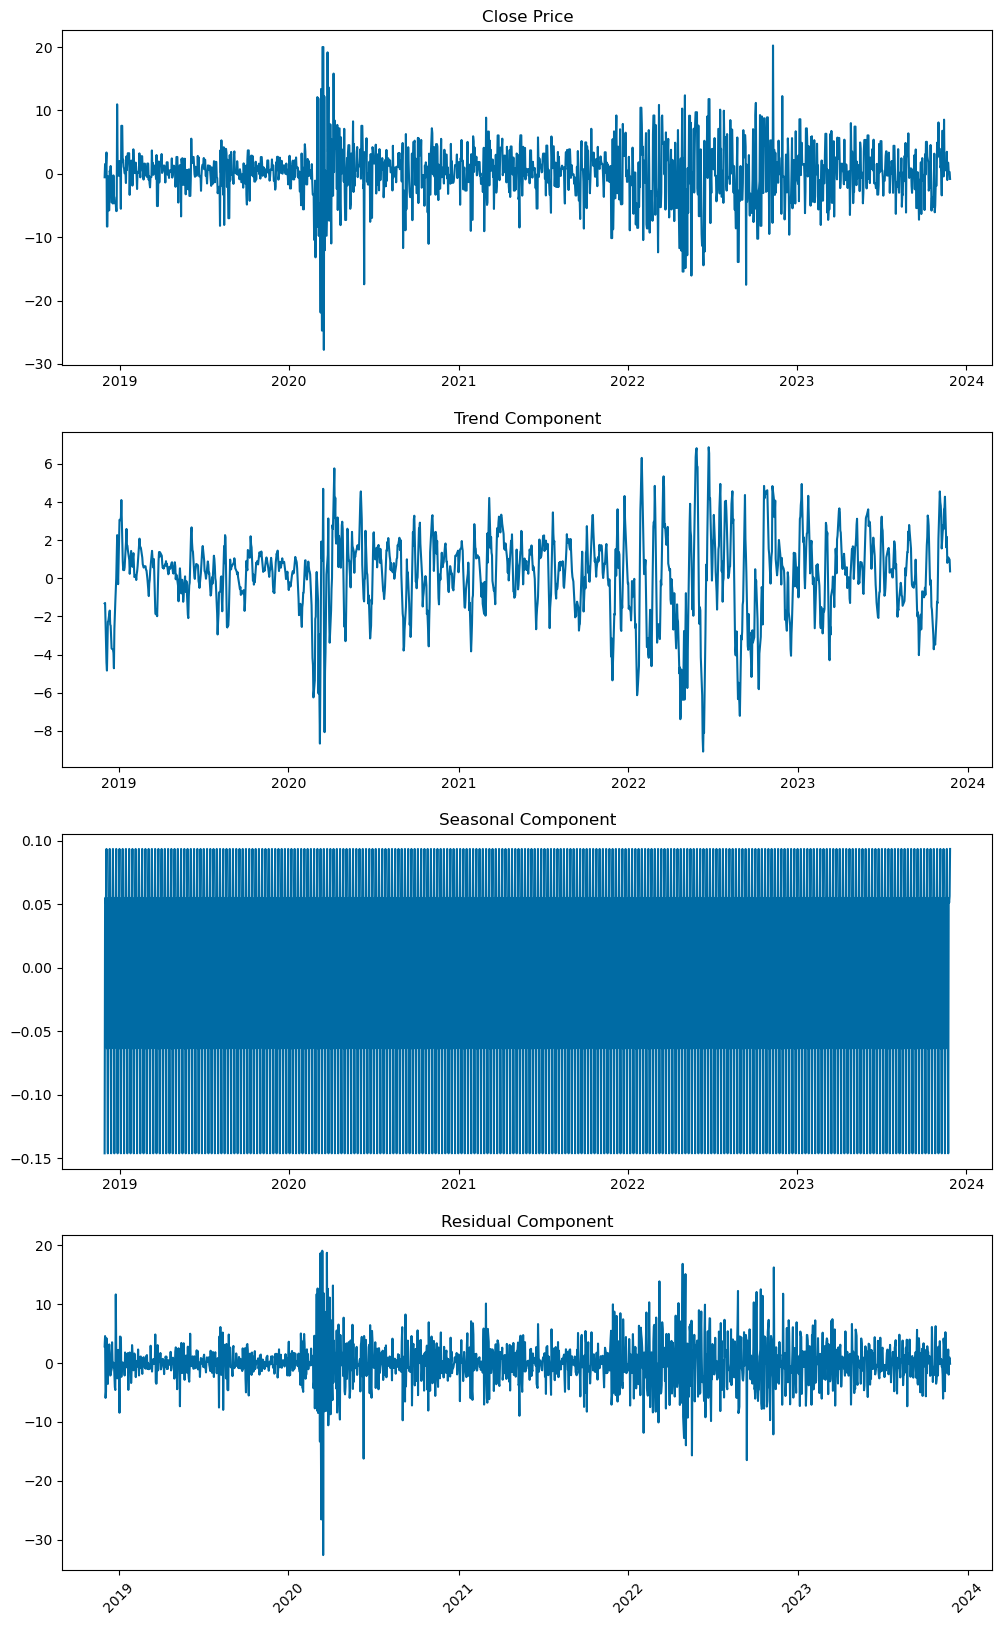

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

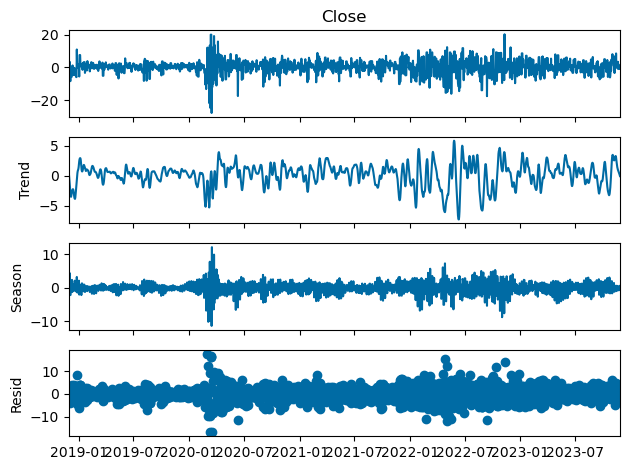

In [21]:
stl = STL(ts_lag_1).fit().plot()

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

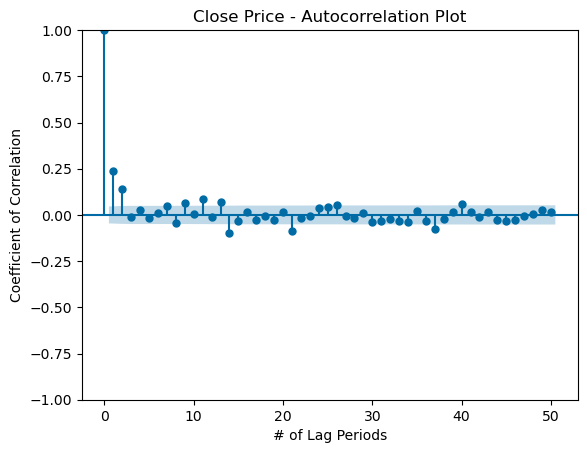

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

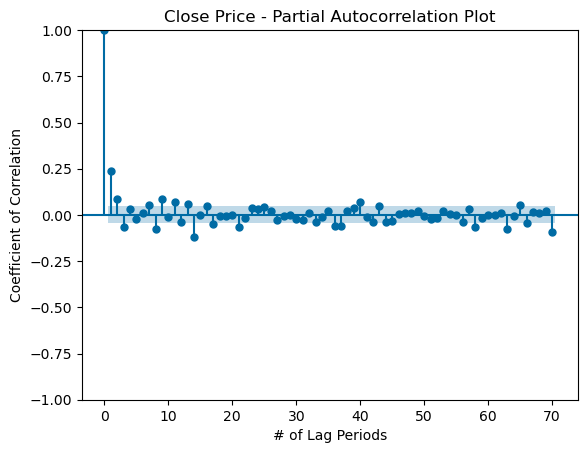

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for AR(1): 10450.894919953262
BIC for AR(1): 10467.421281465164


AIC for AR(2): 10439.217009551574
BIC for AR(2): 10461.25215823411


AIC for AR(3): 10433.95552848255
BIC for AR(3): 10461.49946433572


AIC for AR(8): 10425.550046071152
BIC for AR(8): 10480.637917777494


AIC for AR(9): 10413.35266521385
BIC for AR(9): 10473.949324090827


AIC for AR(11): 10408.163906574086
BIC for AR(11): 10479.778139792332


AIC for AR(14): 10377.434633553992
BIC for AR(14): 10465.57522828414


AIC for AR(21): 10375.13764190095
BIC for AR(21): 10501.839746825539




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for MA(0): 10482.148748281008
BIC for MA(0): 10564.780555840522


AIC for MA(1): 10377.434633553992
BIC for MA(1): 10465.57522828414


AIC for MA(2): 10406.690659097758
BIC for MA(2): 10500.34004099854


AIC for MA(11): 10369.641663081675
BIC for MA(11): 10512.870129518165


AIC for MA(13): 10363.692509606068
BIC for MA(13): 10517.938550383828


AIC for MA(14): 10367.7020498059
BIC for MA(14): 10527.456877754294


AIC for MA(21): 10371.715499773047
BIC for MA(21): 10570.031837915882


AIC for MA(37): 10359.873020708972
BIC for MA(37): 10646.329953581955


AIC for MA(40): 10363.111621404627
BIC for MA(40): 10666.094915789512




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10377.434633553992
BIC = 10465.57522828414
Time Series Evaluation Metrics
MSE = 174913.69069601333
MAE = 417.59783684885946
RMSE = 418.2268411950784
MAPE = 0.9995388204943552
r2 = -331.4623890368903



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3543.0689696795707
BIC = 3577.458169423023
Time Series Evaluation Metrics
MSE = 1108.462996138112
MAE = 27.0940693899913
RMSE = 33.293587913262094
MAPE = 0.0626875434605103
r2 = -1.1068805671451392

Results for Seasonal Period 3
AIC = 3853.7686389603987
BIC = 3893.070581524344
Time Series Evaluation Metrics
MSE = 1094.3627980781832
MAE = 26.997934048434388
RMSE = 33.08115472709777
MAPE = 0.062477563973663004
r2 = -1.080080003311378

Results for Seasonal Period 8
AIC = 4429.8433539952375
BIC = 4493.709010661649
Time Series Evaluation Metrics
MSE = 1749.3022834580154
MAE = 39.40015541671925
RMSE = 41.824661187605756
MAPE = 0.09465490218570641
r2 = -2.324938225200886

Results for Seasonal Period 9
AIC = 4447.579915862036
BIC = 4516.35831534894
Time Series Evaluation Metrics
MSE = 3012.1275198042
MAE = 52.01534047863219
RMSE = 54.88285269375308
MAPE = 0.12441342606905896
r2 = -4.725218576848039

Results for Seasonal Period 11
AIC = 4535.6070544616605
BIC

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3893.740070678952
BIC = 3928.1292704224043
Time Series Evaluation Metrics
MSE = 1289.599515403195
MAE = 30.496515851572216
RMSE = 35.91099435274934
MAPE = 0.07251722780323117
r2 = -1.4511708265128629

Results for Seasonal mul
AIC = 3891.8692173424934
BIC = 3926.2584170859454
Time Series Evaluation Metrics
MSE = 1469.7865770655567
MAE = 32.726128460123256
RMSE = 38.33779567301121
MAPE = 0.07772450951547782
r2 = -1.7936564304437597

Results for Seasonal additive
AIC = 3893.740070678952
BIC = 3928.1292704224043
Time Series Evaluation Metrics
MSE = 1289.599515403195
MAE = 30.496515851572216
RMSE = 35.91099435274934
MAPE = 0.07251722780323117
r2 = -1.4511708265128629

Results for Seasonal multiplicative
AIC = 3891.8692173424934
BIC = 3926.2584170859454
Time Series Evaluation Metrics
MSE = 1469.7865770655567
MAE = 32.726128460123256
RMSE = 38.33779567301121
MAPE = 0.07772450951547782
r2 = -1.7936564304437597

Results for Seasonal None
AIC = 4638.890770848857
BI

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [32]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3853.740357070036
BIC = 3893.0422996339817
Time Series Evaluation Metrics
MSE = 1113.7878032224608
MAE = 27.246292899364988
RMSE = 33.37345956328862
MAPE = 0.06304519777771886
r2 = -1.1170015478264048

Results for Trend mul
AIC = 3883.5111327827262
BIC = 3922.8130753466717
Time Series Evaluation Metrics
MSE = 226.93350286838438
MAE = 12.880555557707522
RMSE = 15.064312226862015
MAPE = 0.031060771670176953
r2 = 0.5686623830535142

Results for Trend additive
AIC = 3853.740357070036
BIC = 3893.0422996339817
Time Series Evaluation Metrics
MSE = 1113.7878032224608
MAE = 27.246292899364988
RMSE = 33.37345956328862
MAPE = 0.06304519777771886
r2 = -1.1170015478264048

Results for Trend multiplicative
AIC = 3883.5111327827262
BIC = 3922.8130753466717
Time Series Evaluation Metrics
MSE = 226.93350286838438
MAE = 12.880555557707522
RMSE = 15.064312226862015
MAPE = 0.031060771670176953
r2 = 0.5686623830535142



ValueError: Can only dampen the trend component

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [33]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3883.512377559457
BIC = 3922.8143201234025
Time Series Evaluation Metrics
MSE = 226.93343820765932
MAE = 12.88055456759323
RMSE = 15.064310080705964
MAPE = 0.031060770209670237
r2 = 0.5686625059556099

Results for Damped Trend False
AIC = 3893.740577489577
BIC = 3928.129777233029
Time Series Evaluation Metrics
MSE = 1289.5962521174765
MAE = 30.496471523611408
RMSE = 35.910948916973446
MAPE = 0.07251712319595191
r2 = -1.4511646239122444



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3893.4683831253164
BIC = 3927.8575828687685
Time Series Evaluation Metrics
MSE = 704.2292284979661
MAE = 22.256857794544995
RMSE = 26.537317658308385
MAPE = 0.053401820660268114
r2 = -0.33854434609661044

Results for Initialization Method estimated
AIC = 3893.201670638151
BIC = 3927.590870381603
Time Series Evaluation Metrics
MSE = 703.1007357604493
MAE = 22.23638626763246
RMSE = 26.516046759659506
MAPE = 0.05335391003220961
r2 = -0.33639939454917767

Results for Initialization Method heuristic
AIC = 3898.081533492079
BIC = 3932.470733235531
Time Series Evaluation Metrics
MSE = 701.778519812533
MAE = 22.212591768350748
RMSE = 26.491102653769115
MAPE = 0.053298190924980476
r2 = -0.3338862289352238

Results for Initialization Method legacy-heuristic
AIC = 3893.4683831253164
BIC = 3927.8575828687685
Time Series Evaluation Metrics
MSE = 704.2292284979661
MAE = 22.256857794544995
RMSE = 26.537317658308385
MAPE = 0.053401820660268114
r2 = -0.33854

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [35]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3883.5113795570815
BIC = 3922.813322121027
Time Series Evaluation Metrics
MSE = 226.933550685858
MAE = 12.880558180230286
RMSE = 15.064313813973008
MAPE = 0.03106078245687623
r2 = 0.5686622921657659

None


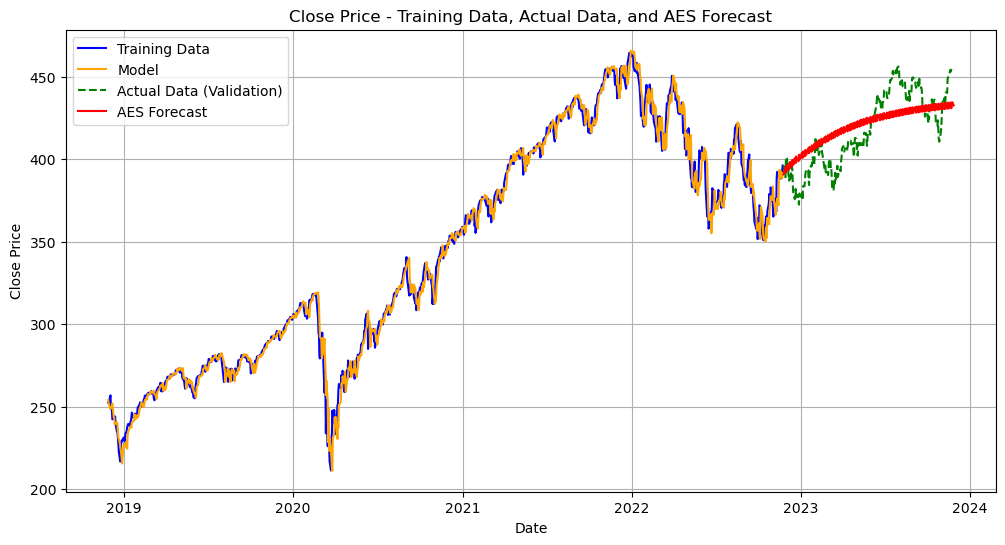

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [ ]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [ ]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


In [ ]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

In [ ]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [ ]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

In [ ]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [ ]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

In [ ]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

In [ ]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

## Amazon  - Gabi in progress

In [ ]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

In [ ]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

In [ ]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [ ]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [ ]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [ ]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [ ]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

In [ ]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

In [ ]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal # from STL
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [ ]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

In [ ]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
#plt.xlabel('Year')
#plt.ylabel('Closing Price')

In [ ]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

### Transforming Time Series to Stationary

In [ ]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [ ]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

### Selecting a Model

In [ ]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [ ]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

In [ ]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

In [ ]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    